In [1]:
#!/usr/bin/env python3

from env.MjEnv import MjEnv
import numpy as np
from matplotlib import pyplot as plt

# create and prepare the mujoco instance
mj = MjEnv()
mj.testing_xmls = 0

# define the names of the object sets we want to investigate
object_sets = [
  "set_test_seg5",
  "set_test_seg6",
  "set_test_seg7",
  "set_test_seg8",
  "set_test_seg9",
  "set_test_seg10",
  "set_test_seg15",
  "set_test_seg20",
  "set_test_seg30"
]

# list of stable timesteps for each object set
mujoco_timesteps = [
  0.00353,
  0.0024,
  0.00176,
  0.00133,
  0.00102,
  0.000841,
  0.000334,
  0.000198,
  8.42E-05
]

# initialise/wipe variables
data = []
num_sets = len(object_sets)

In [8]:
from FEA_data import FEA_1N, FEA_5N

FEA_xy = [1e-3 * np.array(FEA_1N), 1e-3 * np.array(FEA_5N)]

In [3]:
# TODO: add in code to detect automatically the highest stable timestep

In [4]:
# loop through each object set and gather data
done_one = False
for i in range(0, num_sets):

  # if done_one: break

  mj._load_object_set(name=object_sets[i])
  mj._load_xml()
  mj.mj.set.mujoco_timestep = mujoco_timesteps[i] * 0.5
  mj.task_reload_chance = -1
  mj.mj.hard_reset()
  mj.reset()

  # run the validation regime
  print("Curve validation running for object set:", object_sets[i])
  print_out = False
  finger_data = mj.mj.curve_validation_regime(print_out)
  data.append(finger_data)

  done_one = True

Curve validation running for object set: set_test_seg5
Curve validation running for object set: set_test_seg6
Curve validation running for object set: set_test_seg7
Curve validation running for object set: set_test_seg8
Curve validation running for object set: set_test_seg9
Curve validation running for object set: set_test_seg10
Curve validation running for object set: set_test_seg15
Curve validation running for object set: set_test_seg20
Curve validation running for object set: set_test_seg30


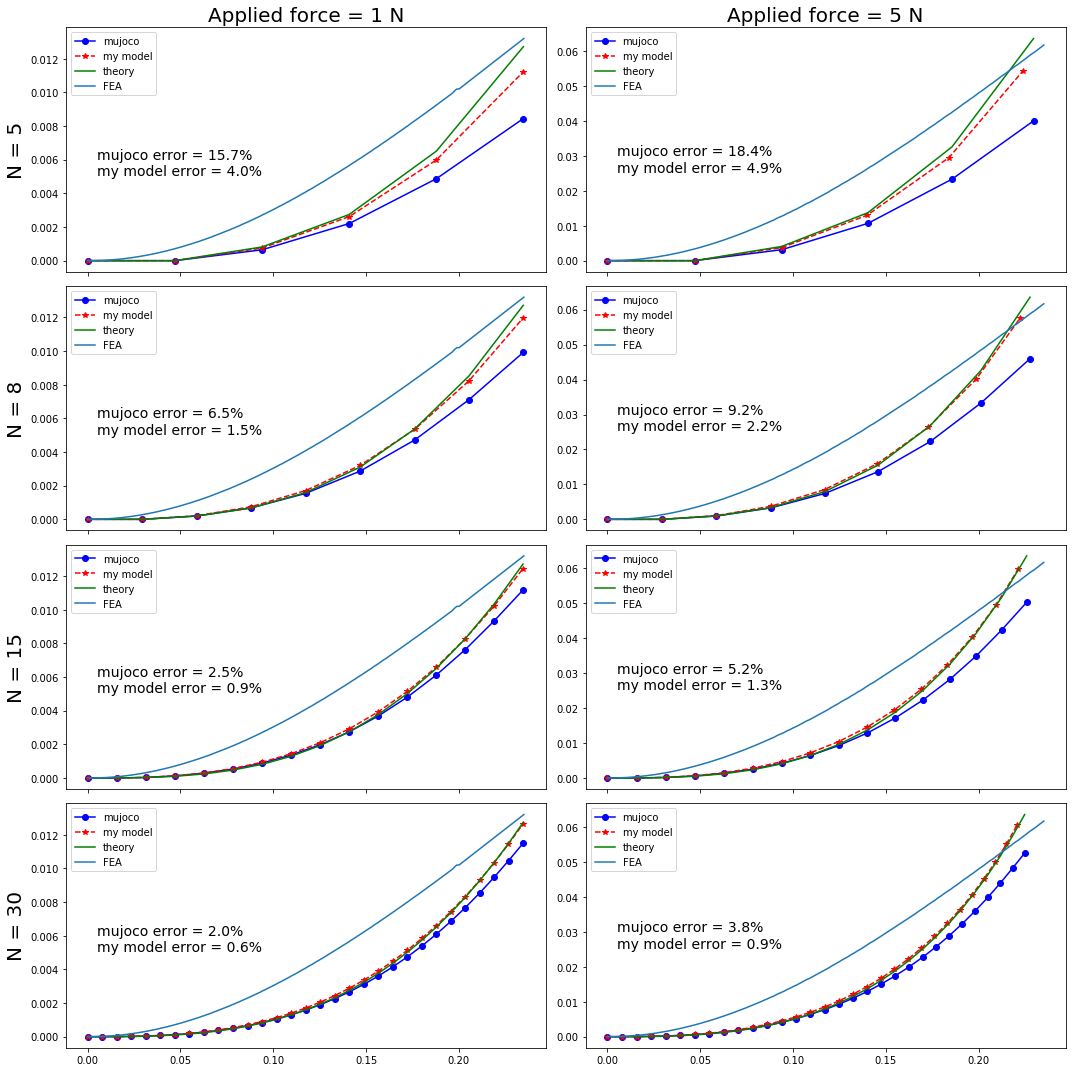

In [14]:
# now process the data and plot it

entries = list(range(num_sets))
entries = [0, 3, 6, 8]

fig, axs = plt.subplots(len(entries), 2, sharex=True)

for i, force in enumerate([1, 5]):
  for j, ind in enumerate(entries):

    # lets start by plotting a basic example
    x =        np.array(data[ind].entries[force - 1].f1.x)
    pred_x =   np.array(data[ind].entries[force - 1].f1.pred_x)
    y =        np.array(data[ind].entries[force - 1].f1.y)
    pred_y =   np.array(data[ind].entries[force - 1].f1.pred_y)
    theory_y = np.array(data[ind].entries[force - 1].f1.theory_y)

    # add in (0,0)
    # x = x.insert(0, 0)
    # pred_x = pred_x.insert(0, 0)
    # y = y.insert(0, 0)
    # pred_y = pred_y.insert(0, 0)
    # theory_

    x = np.insert(x, 0, 0)
    pred_x = np.insert(pred_x, 0, 0)
    y = np.insert(y, 0, 0)
    pred_y = np.insert(pred_y, 0, 0)
    theory_y = np.insert(theory_y, 0, 0)

    axs[j][i].plot(x,      y,        "b-o",  label="mujoco")
    axs[j][i].plot(pred_x, pred_y,   "r--*", label="my model")
    axs[j][i].plot(x,      theory_y, "g",    label="theory")
    axs[j][i].plot(FEA_xy[i][:,0], FEA_xy[i][:,1], label="FEA")
    
    temp_N = len(data[ind].entries[force - 1].f1.y)
    axs[j][i].text(0.005, data[ind].entries[force - 1].f1.theory_y[temp_N - 1] * 0.4,
      f"mujoco error = {100 * data[ind].entries[force - 1].f1.error.y_wrt_theory_y_tipratio:.1f}%" +
      f"\nmy model error = {100 * data[ind].entries[force - 1].f1.error.y_pred_wrt_theory_y_tipratio:.1f}%",
      fontsize=14)
    # axs[j][i].axis("equal")
    axs[j][i].legend()

    if j == 0:
      axs[j][i].set_title(f"Applied force = {force} N", fontsize=20)
    if i == 0:
      axs[j][i].set_ylabel(f"N = {temp_N}", fontsize=20, rotation=90)

fig.set_size_inches(15, 15)
fig.tight_layout()